## Data Preparation

In [1]:
import json
with open('action_types.json', 'r') as f:
    action_types = json.load(f)

import pandas as pd
from preprocess_data import *
df = (
    pd.read_csv("WSL_actions.csv", index_col = 0)
    .pipe(add_coordinate_bins, n_bins_x = 10, n_bins_y = 10)
    .pipe(add_team_as_dummy)
    .pipe(get_action_type_names, action_types)
    .pipe(get_action_tokens)
    .assign(
        group_id = lambda d: d.groupby(['game_id', 'period_id']).ngroup(),
        action_token = lambda d: pd.Categorical(d.action_token)
    )
    [['group_id', 'action_token']]
)

vocab = df['action_token'].cat.categories

from numpy.random import choice, seed
seed(42)
train_groups = choice(df['group_id'].unique(), int(0.8 * df['group_id'].nunique()), replace = False)
val_groups = choice(train_groups, int(0.8 * len(train_groups)), replace = False)
train_groups[:5]

array([ 55, 363, 406, 428, 402], dtype=int64)

In [2]:
train_df = df.query("group_id.isin(@train_groups) and ~group_id.isin(@val_groups)")
val_df = df.query("group_id.isin(@val_groups)")

X_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (3,))[:-1]
y_train = np.lib.stride_tricks.sliding_window_view(train_df['action_token'].map(list(vocab).index), (3,))[1:]

X_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (3,))[:-1]
y_val = np.lib.stride_tricks.sliding_window_view(val_df['action_token'].map(list(vocab).index), (3,))[1:]

## Prepare Model

In [3]:
import torch
from models import BasicTransformer

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = BasicTransformer(len(vocab), 128, 128, 2, 2, 0.1).to(device=device)
model.load_state_dict(torch.load("transformer_weights.pkl", map_location=torch.device('cpu')))
model.eval()

BasicTransformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=2856, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (input_emb): Embedding(2856, 128)
)

## Model Evaluation

In [4]:
!pip install matplotsoccer


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import matplotsoccer as pltsoc

In [6]:
def x_bin_to_coords(bin):
    return (float(bin) + 0.5) * 10.5

def y_bin_to_coords(bin):
    return (float(bin) + 0.5) * 6.8

def plot_action_sequence(tokens):
    team = ["home" if t.split(',')[0] == "True" else "away" for t in tokens]
    action = [t.split(',')[1] for t in tokens]
    x_coord = [x_bin_to_coords(t.split(',')[2]) for t in tokens]
    y_coord = [y_bin_to_coords(t.split(',')[3]) for t in tokens]
    coords = list(zip(x_coord, y_coord))
    
    pltsoc.actions(
        coords,
        team = team,
        action_type = action,
        label = [[team[i], action[i]] for i in range(len(team))],
        labeltitle=["team","action type"]
    )

C:\Users\ethan\AppData\Local\Temp\ipykernel_35516\2204606361.py:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)


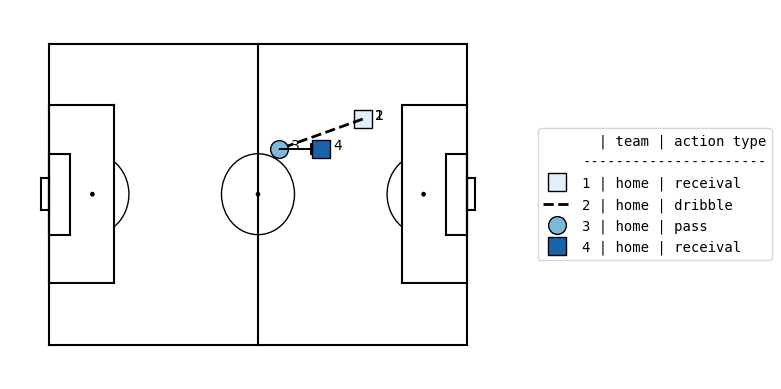

In [7]:
pid = 200

model.eval()
output = model(torch.from_numpy(X_train[pid])).argmax(dim=-1)
play = output[0,-1].item()
sequence = list(X_train[pid]) + [play]
plot_action_sequence([vocab[i] for i in sequence])
